<a href="https://colab.research.google.com/github/KacperBytnar/Bitcoin_Price_Prediction/blob/main/Kacper_Bytnar_Synopsis_Bitcoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

import plotly.graph_objs as go

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import data_table
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

### Importing the historical data from 2014-09-17 till now

In [25]:
 # Read the CSV file
df = pd.read_csv('Daily_Bitcoin.csv')
df = df.drop(df.index[-1])
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-05-21,27118.423828,27265.917969,26706.921875,26753.826172,26753.826172,8647416921
2023-05-22,26749.892578,27045.734375,26549.734375,26851.277344,26851.277344,11056770492
2023-05-23,26855.960938,27434.683594,26816.179688,27225.726563,27225.726563,13697203143


### Importing the wikipedia sentiment analysis and merging the datasets

In [26]:
wiki_df = pd.read_csv("sentiment_analysis.csv", index_col=0, parse_dates=True)
wiki_df

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2023-05-22,0.066667,-0.000186,0.016667
2023-05-23,0.066667,-0.000186,0.016667
2023-05-24,0.133333,-0.033500,0.050000
2023-05-25,0.133333,-0.033500,0.050000


In [27]:
df = df.merge(wiki_df, left_index=True, right_index=True)
df

,Open,High,Low,Close,Adj Close,Volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,5.033333,-0.232191,0.532718
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,5.066667,-0.232760,0.532718
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,5.200000,-0.235415,0.549385
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,5.200000,-0.233185,0.549385
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...,...
2023-05-21,27118.423828,27265.917969,26706.921875,26753.826172,26753.826172,8647416921,0.100000,-0.033484,0.050000
2023-05-22,26749.892578,27045.734375,26549.734375,26851.277344,26851.277344,11056770492,0.066667,-0.000186,0.016667
2023-05-23,26855.960938,27434.683594,26816.179688,27225.726563,27225.726563,13697203143,0.066667,-0.000186,0.016667
2023-05-24,27224.603516,27224.603516,26106.576172,26334.818359,26334.818359,16299104428,0.133333,-0.033500,0.050000


### Exploring the dataset

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2014-09-17 to 2023-05-25
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           3173 non-null   float64
 1   High           3173 non-null   float64
 2   Low            3173 non-null   float64
 3   Close          3173 non-null   float64
 4   Adj Close      3173 non-null   float64
 5   Volume         3173 non-null   int64  
 6   edit_count     3173 non-null   float64
 7   sentiment      3173 non-null   float64
 8   neg_sentiment  3173 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 247.9 KB


In [29]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,edit_count,sentiment,neg_sentiment
count,3173.000000,3173.000000,3173.000000,3173.000000,3173.000000,3.173000e+03,3173.000000,3173.000000,3173.000000
mean,13406.207711,13736.849681,13042.153126,13413.004763,13413.004763,1.659728e+10,2.459313,-0.208364,0.344610
std,16032.303893,16436.721318,15568.213962,16029.051609,16029.051609,1.964587e+10,2.872425,0.134250,0.177853
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,0.033333,-0.551465,0.016667
25%,740.442017,747.614990,732.484009,740.828979,740.828979,1.217200e+08,0.666667,-0.316195,0.188889
50%,7486.479980,7643.229980,7328.649902,7493.488770,7493.488770,9.713268e+09,1.300000,-0.180551,0.311905
75%,19427.779297,19870.628906,19079.841797,19431.789063,19431.789063,2.777333e+10,3.366667,-0.107618,0.500547
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,16.766667,0.081980,0.751244


In [30]:
corr = df.corr()
print(corr)

                   Open      High       Low     Close  Adj Close    Volume  \
Open           1.000000  0.999504  0.999099  0.998785   0.998785  0.710567   
High           0.999504  1.000000  0.998994  0.999459   0.999459  0.714753   
Low            0.999099  0.998994  1.000000  0.999366   0.999366  0.702189   
Close          0.998785  0.999459  0.999366  1.000000   1.000000  0.709250   
Adj Close      0.998785  0.999459  0.999366  1.000000   1.000000  0.709250   
Volume         0.710567  0.714753  0.702189  0.709250   0.709250  1.000000   
edit_count    -0.344706 -0.342960 -0.348005 -0.345211  -0.345211 -0.408638   
sentiment      0.393123  0.391320  0.396017  0.393384   0.393384  0.423932   
neg_sentiment -0.389752 -0.387295 -0.394174 -0.390315  -0.390315 -0.473679   

               edit_count  sentiment  neg_sentiment  
Open            -0.344706   0.393123      -0.389752  
High            -0.342960   0.391320      -0.387295  
Low             -0.348005   0.396017      -0.394174  
Clo

### EDA (Exploratory Data Analysis)

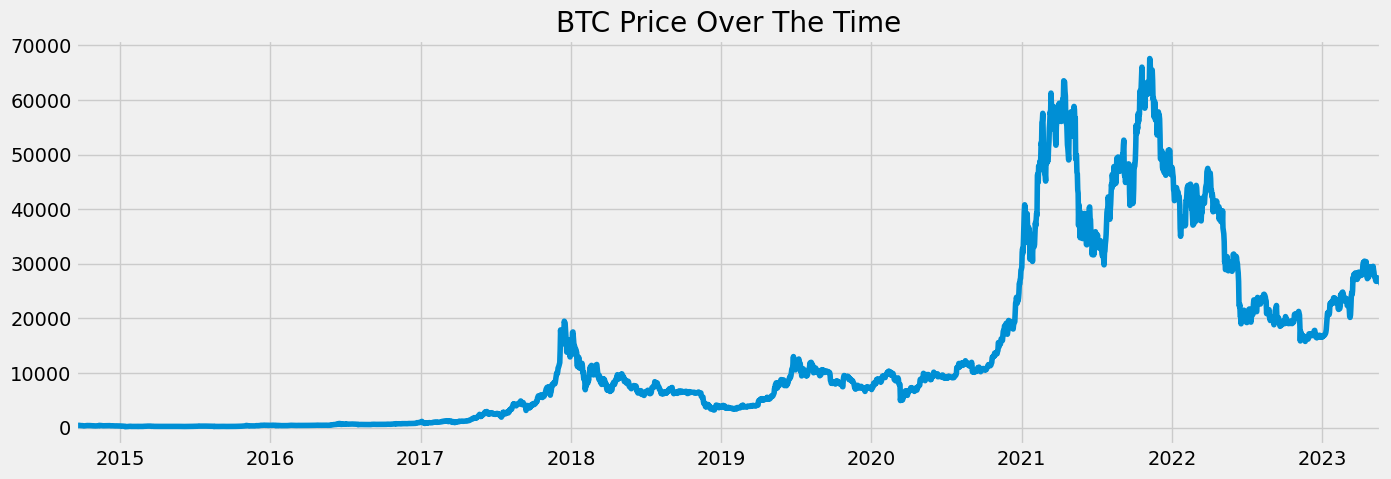

In [31]:
df['Close'].plot(style='-',
        figsize=(15, 5), 
        title='BTC Price Over The Time')
plt.show()

In [32]:
import plotly.graph_objects as go

# Declare a figure
fig = go.Figure()
# Candlestick chart
fig.add_trace(go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'], 
                name = 'Bitcoin Data'))

### Creating Features

Target feature used for predictions

In [33]:
df["tomorrow"] = df["Close"].shift(-1)


Several technical analysis factors have been calculated.
These factors play a crucial role in Bitcoin price prediction due to their ability to capture important market dynamics.

In [34]:
# Calculate the 20-day moving average of the closing prices
df['moving_avg'] = df['Close'].rolling(window=20).mean()

# Calculate the 12-day exponential moving average of the closing prices
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-day exponential moving average of the closing prices
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()

# Calculate the Moving Average Convergence Divergence (MACD) indicator
# by taking the difference between the 12-day and 26-day EMA
df['macd'] = df['ema_12'] - df['ema_26']

# Calculate the signal line for the MACD indicator
# by taking the 9-day EMA of the MACD
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Calculate the difference between each closing price and the previous closing price
delta = df['Close'].diff()

# Set the gain to the difference if it's positive, otherwise set it to 0
gain = delta.where(delta > 0, 0)

# Set the loss to the negative difference if it's negative, otherwise set it to 0
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and average loss over a 14-day period
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate the Relative Strength Index (RSI) using the average gain and average loss
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Calculate the Aroon Up indicator using a rolling window of 25 days
aroon_up = 100 * ((25 - (df['Close'].rolling(25).apply(lambda x: x.argmax() + 1))) / 25)

# Calculate the Aroon Down indicator using a rolling window of 25 days
aroon_down = 100 * ((25 - (df['Close'].rolling(25).apply(lambda x: x.argmin() + 1))) / 25)

# Calculate the Aroon Oscillator by subtracting the Aroon Down from the Aroon Up
df['aroon_oscillator'] = aroon_up - aroon_down

# Display the last few rows of the DataFrame, including the new columns that were added
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,edit_count,sentiment,neg_sentiment,tomorrow,moving_avg,ema_12,ema_26,macd,macd_signal,rsi,aroon_oscillator
2023-05-23,26855.960938,27434.683594,26816.179688,27225.726563,27225.726563,13697203143,0.066667,-0.000186,0.016667,26334.818359,27477.394922,27155.328976,27541.013192,-385.684217,-383.192167,43.836725,64.0
2023-05-24,27224.603516,27224.603516,26106.576172,26334.818359,26334.818359,16299104428,0.133333,-0.033500,0.050000,26476.207031,27351.750293,27029.096573,27451.665427,-422.568854,-391.067505,35.265291,76.0
2023-05-25,26329.460938,26591.519531,25890.593750,26476.207031,26476.207031,13851122697,0.133333,-0.033500,0.050000,NaN,27198.841406,26944.036644,27379.409249,-435.372606,-399.928525,43.252876,76.0


These three new columns provide additional information and insights about the relationship between the closing price, sentiment-related features, and the target variable over different time horizons. They can potentially help improve the predictive power of the model by incorporating different aspects of the data and capturing temporal patterns.

Momentum refers to the measure of how quickly a stock price is moving over a specific time period. It helps investors assess the strength of a trend. In this context, momentum (MOM) is calculated using the closing price of the stock. The formula for calculating momentum is as follows:

Momentum = (Close(i) - Close(i - (ζ - 1))) / Close(i - (ζ - 1))

In [35]:
num_days = 14

if len(df) >= num_days:
    df['Momentum'] = (df['Close'] - df['Close'].shift(num_days)) / df['Close'].shift(num_days)
    
horizons = [2,7,60,365]

for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        df[ratio_column] = df["Close"] / rolling_averages["Close"]
        
        edit_column = f"edit_{horizon}"
        df[edit_column] = rolling_averages["edit_count"]

        rolling = df.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        df[trend_column] = rolling["tomorrow"]




In [36]:
df


,Open,High,Low,Close,Adj Close,Volume,edit_count,sentiment,neg_sentiment,tomorrow,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,...,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,...,424.440002,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,...,409.617996,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,...,401.849991,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,...,403.862503,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-21,27118.423828,27265.917969,26706.921875,26753.826172,26753.826172,8647416921,0.100000,-0.033484,0.050000,26851.277344,...,26941.706055,0.989658,0.100000,27033.413783,0.945609,0.309444,28292.689128,1.197653,0.640183,22338.543600
2023-05-22,26749.892578,27045.734375,26549.734375,26851.277344,26851.277344,11056770492,0.066667,-0.000186,0.016667,27225.726563,...,26802.551758,0.995058,0.095238,26984.640067,0.949883,0.297222,28267.977539,1.202528,0.636804,22329.030051
2023-05-23,26855.960938,27434.683594,26816.179688,27225.726563,27225.726563,13697203143,0.066667,-0.000186,0.016667,26334.818359,...,27038.501953,1.007925,0.090476,27011.650949,0.963282,0.285556,28263.518229,1.219578,0.633425,22323.898042
2023-05-24,27224.603516,27224.603516,26106.576172,26334.818359,26334.818359,16299104428,0.133333,-0.033500,0.050000,26476.207031,...,26780.272461,0.980460,0.095238,26859.653181,0.932398,0.275556,28244.186751,1.180150,0.629680,22314.800048


In [37]:
df.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)

### Explore the Correlation between numerical features

In [38]:
# Get the correlations of the data
corr = df.corr()

# Display Correlations of profit only
print("Correlations of Closing price only:")
corr['Close'].sort_values(ascending=False)


Correlations of Closing price only:


Close               1.000000
trend_2             0.999698
tomorrow            0.998791
trend_7             0.997757
ema_12              0.996833
moving_avg          0.992032
ema_26              0.992009
trend_60            0.971719
trend_365           0.823942
Volume              0.709250
sentiment           0.393384
macd_signal         0.178567
macd                0.164644
close_ratio_365     0.144063
close_ratio_60      0.038143
aroon_oscillator    0.032181
Momentum            0.016430
close_ratio_7       0.003861
close_ratio_2       0.001622
rsi                -0.035201
edit_count         -0.345211
edit_2             -0.345713
edit_7             -0.349062
neg_sentiment      -0.390315
edit_60            -0.392926
edit_365           -0.536952
Name: Close, dtype: float64

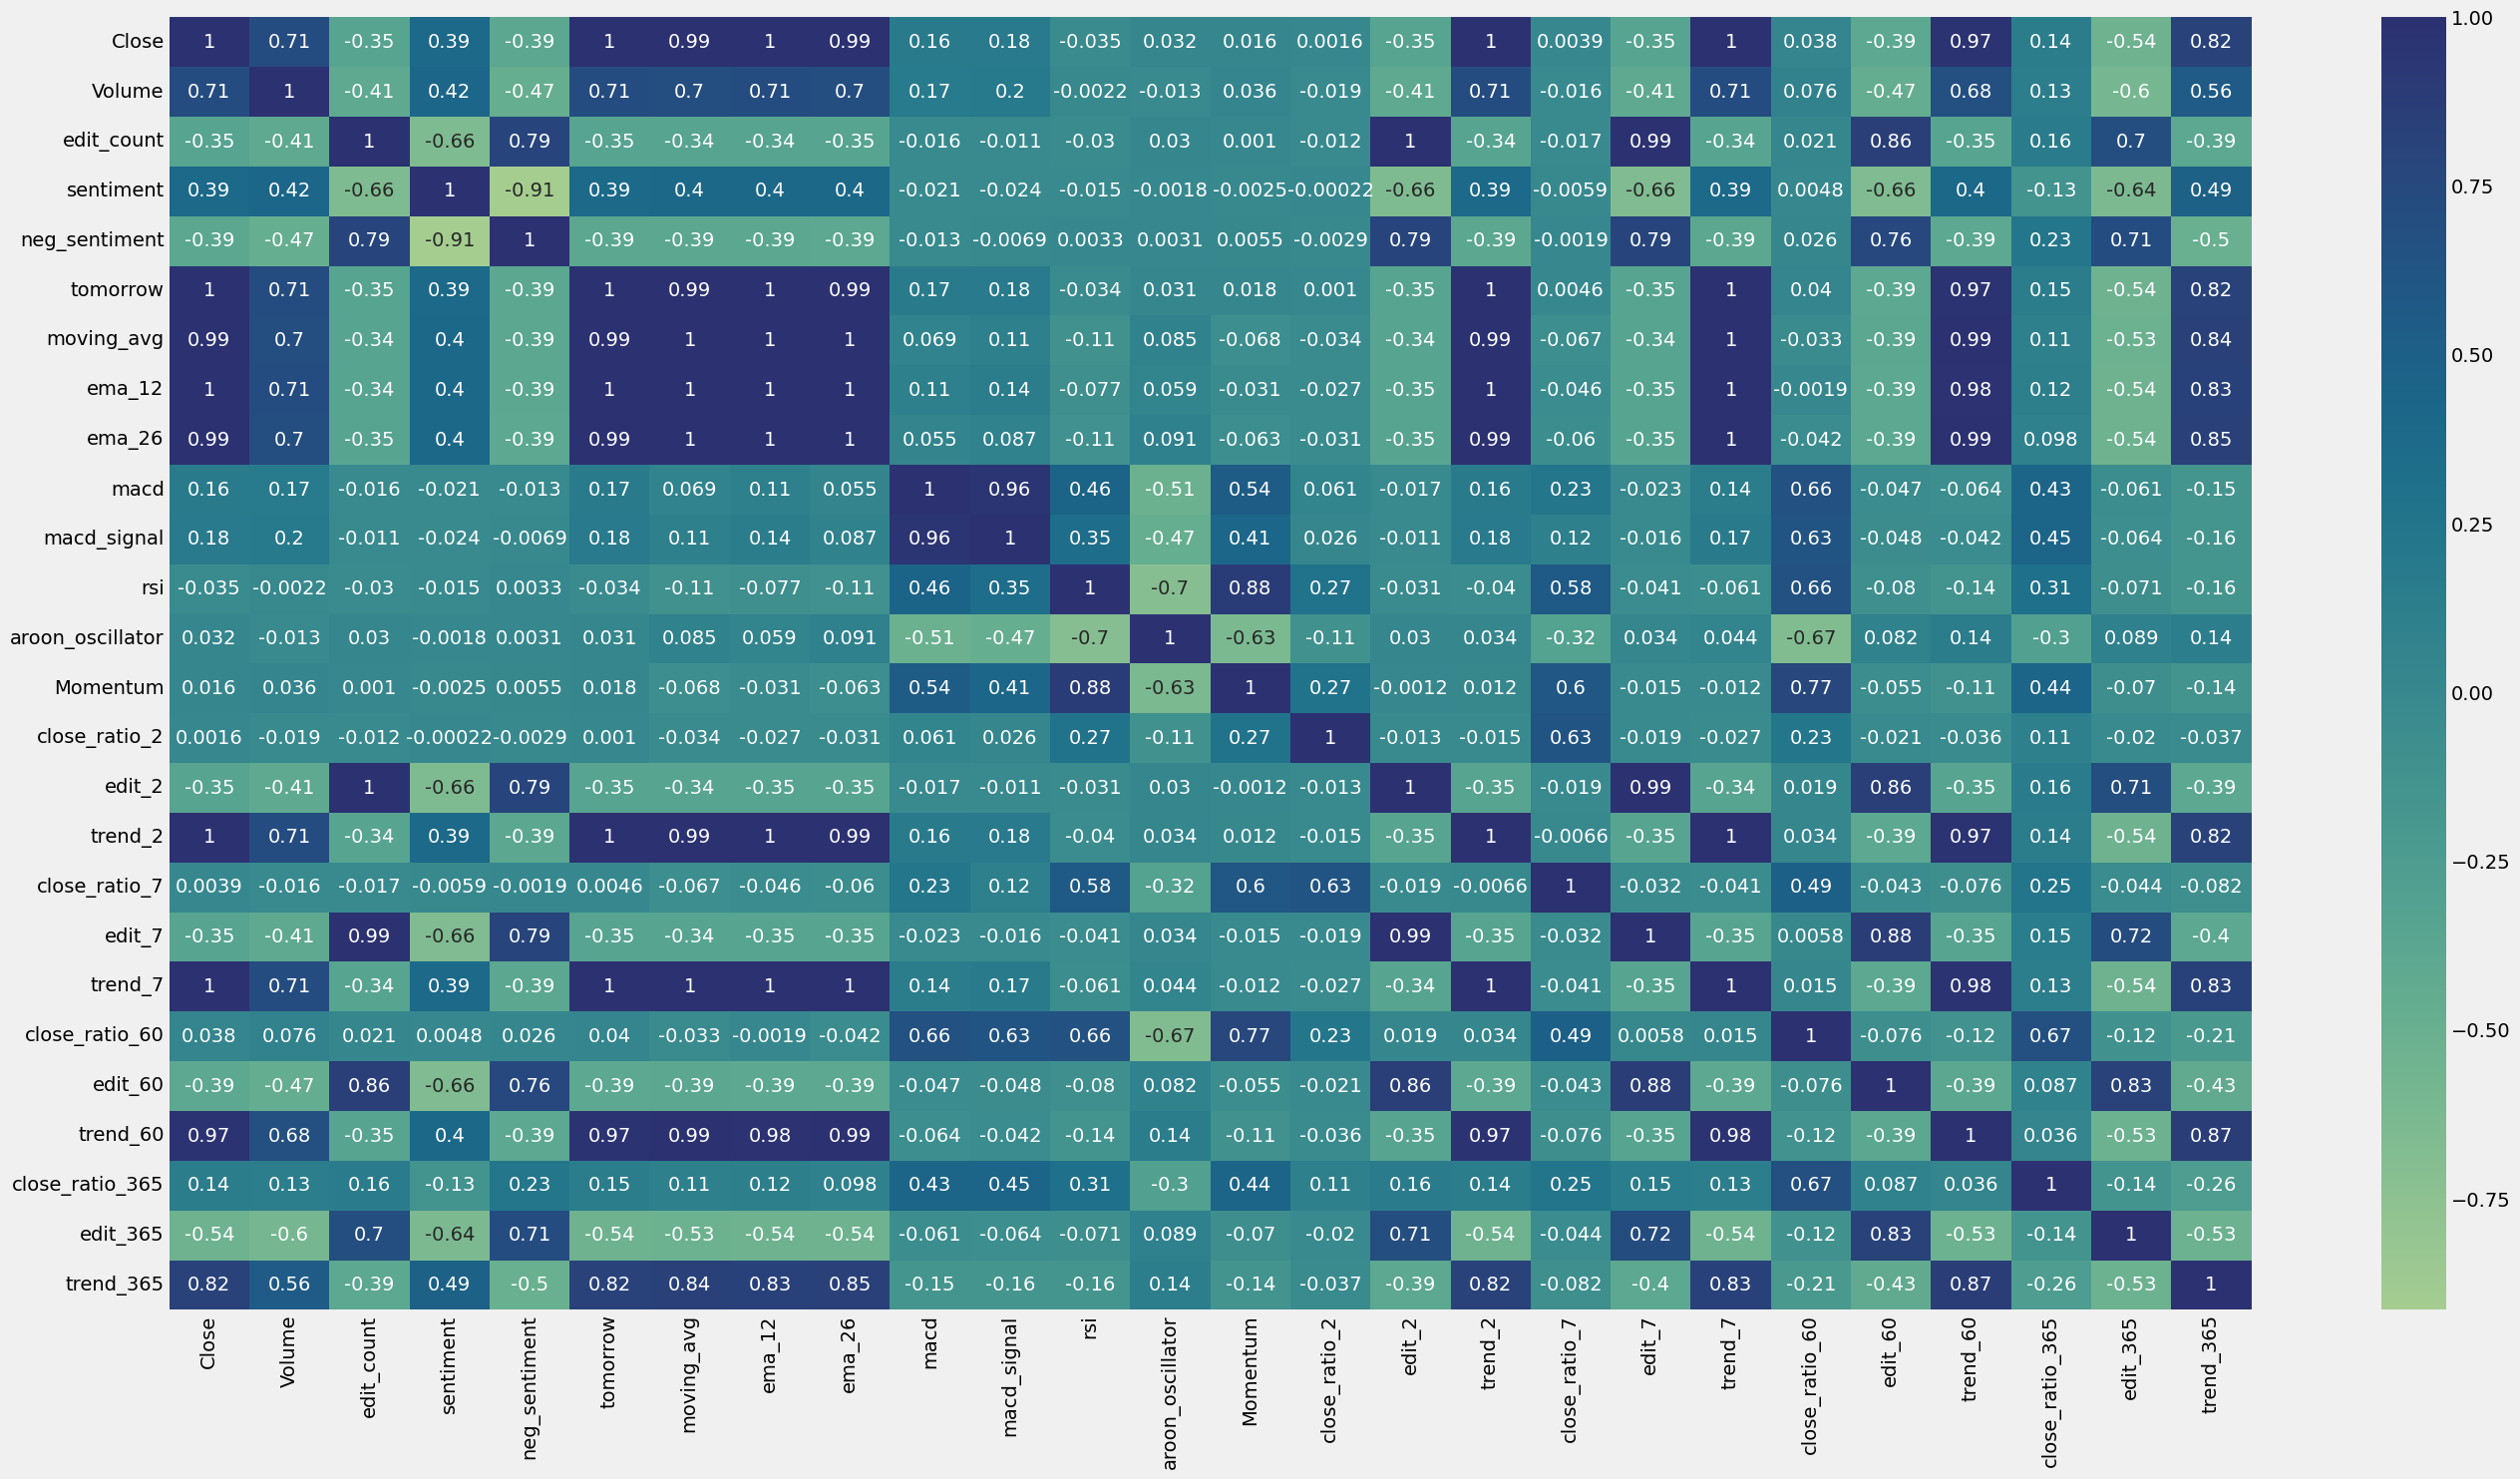

In [39]:
# Heatmap
plt.figure(figsize=(30, 16))
sns.heatmap(df.corr(), annot=True, cmap='crest')
plt.show()

### Inferences from correlation matrix

1. The closing price of Bitcoin has a very strong positive correlation with variables like "BTC+1," "BTC+2," "ema_12," and "BTC+3," indicating they are good predictors for future price.

2. The closing price also has a strong positive correlation with "moving_avg" and "ema_26," suggesting that these moving average indicators are closely related to the closing price.

3. The correlations between the closing price and "macd_signal" and "macd" are weak but positive, indicating a relatively lower significance of these variables.

4. The "aroon_oscillator" shows a weak positive correlation, while the "rsi" has a weak negative correlation with the closing price. However, these correlations are close to zero, suggesting a minor relationship.

In [40]:
#no rsi on head
df.fillna(df.mean(), inplace=True)
data = df.fillna(method='bfill')
final_data = data.fillna(method='ffill')
final_data.tail()

,Close,Volume,edit_count,sentiment,neg_sentiment,tomorrow,moving_avg,ema_12,ema_26,macd,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2023-05-21,26753.826172,8647416921,0.100000,-0.033484,0.050000,26851.277344,27657.887012,27195.484336,27623.432825,-427.948489,...,26941.706055,0.989658,0.100000,27033.413783,0.945609,0.309444,28292.689128,1.197653,0.640183,22338.543600
2023-05-22,26851.277344,11056770492,0.066667,-0.000186,0.016667,27225.726563,27566.424024,27142.529414,27566.236123,-423.706708,...,26802.551758,0.995058,0.095238,26984.640067,0.949883,0.297222,28267.977539,1.202528,0.636804,22329.030051
2023-05-23,27225.726563,13697203143,0.066667,-0.000186,0.016667,26334.818359,27477.394922,27155.328976,27541.013192,-385.684217,...,27038.501953,1.007925,0.090476,27011.650949,0.963282,0.285556,28263.518229,1.219578,0.633425,22323.898042
2023-05-24,26334.818359,16299104428,0.133333,-0.033500,0.050000,26476.207031,27351.750293,27029.096573,27451.665427,-422.568854,...,26780.272461,0.980460,0.095238,26859.653181,0.932398,0.275556,28244.186751,1.180150,0.629680,22314.800048
2023-05-25,26476.207031,13851122697,0.133333,-0.033500,0.050000,13417.089148,27198.841406,26944.036644,27379.409249,-435.372606,...,26405.512695,0.987594,0.100000,26808.795759,0.938244,0.265556,28218.884701,1.186936,0.625936,22306.344831


In [41]:
featureSelectionDf = df.copy()
Y = featureSelectionDf['tomorrow']
X = featureSelectionDf.drop(['tomorrow', "Close", "Volume"],axis=1)
from sklearn.preprocessing import RobustScaler, MinMaxScaler


In [42]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, Y)
rf.feature_importances_


array([6.13735242e-05, 1.24802681e-04, 1.31603475e-04, 8.02532820e-05,
       1.39271975e-02, 8.88544776e-04, 1.17804294e-04, 1.68564961e-04,
       1.03730979e-04, 1.00557121e-04, 8.47026689e-05, 4.58615932e-04,
       9.58646625e-05, 9.77699260e-01, 1.94583839e-04, 1.58012216e-04,
       1.32361661e-03, 1.39062202e-04, 1.82931451e-04, 1.28676459e-03,
       1.83677265e-04, 1.36090216e-04, 2.35238590e-03])

In [43]:
import numpy as np
 
importances = rf.feature_importances_
print(importances)
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = featureSelectionDf.columns[2:]
 
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

[6.13735242e-05 1.24802681e-04 1.31603475e-04 8.02532820e-05
 1.39271975e-02 8.88544776e-04 1.17804294e-04 1.68564961e-04
 1.03730979e-04 1.00557121e-04 8.47026689e-05 4.58615932e-04
 9.58646625e-05 9.77699260e-01 1.94583839e-04 1.58012216e-04
 1.32361661e-03 1.39062202e-04 1.82931451e-04 1.28676459e-03
 1.83677265e-04 1.36090216e-04 2.35238590e-03]
 1) edit_2                         0.977699
 2) moving_avg                     0.013927
 3) edit_365                       0.002352
 4) edit_7                         0.001324
 5) edit_60                        0.001287
 6) ema_12                         0.000889
 7) Momentum                       0.000459
 8) trend_2                        0.000195
 9) trend_60                       0.000184
10) close_ratio_60                 0.000183
11) macd                           0.000169
12) close_ratio_7                  0.000158
13) trend_7                        0.000139
14) close_ratio_365                0.000136
15) neg_sentiment               

### Train/Test Split

In [69]:
#size = int(len(df) * 0.8)
#df_train = final_data.iloc[:size]
#df_test = final_data.iloc[size:] 
#print('train shape :', df_train.shape)
#print('validation shape :', df_test.shape)

train shape : (2538, 26)
validation shape : (635, 26)


In [75]:
df_train = final_data[final_data.index < "2021-09"]
df_test = final_data[final_data.index >= "2021-09"]

print('train shape :', df_train.shape)
print('validation shape :', df_test.shape)

train shape : (2541, 26)
validation shape : (632, 26)


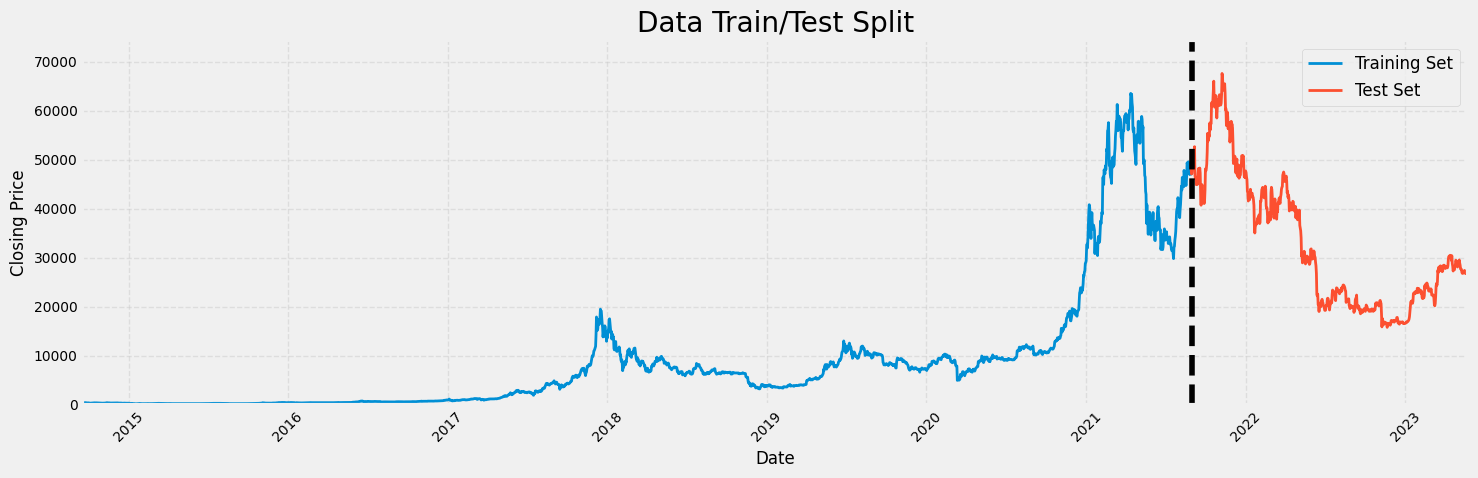

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
df_train['Close'].plot(ax=ax, label='Training Set', title='Data Train/Test Split', linewidth=2)
df_test['Close'].plot(ax=ax, label='Test Set', linewidth=2)
ax.axvline('2021-09-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price', fontsize=12)
ax.set_ylim([0, df['Close'].max() * 1.1])
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [74]:
# Make them on a copy to not drop
y_train = df_train['tomorrow']
y_test = df_test['tomorrow']
x_train = df_train.drop(['Close', 'tomorrow', "edit_365", "edit_60"], axis =1)
x_test = df_test.drop(['Close', 'tomorrow', "edit_365", "edit_60"], axis = 1)

x_train.head(5)


,Volume,edit_count,sentiment,neg_sentiment,moving_avg,ema_12,ema_26,macd,macd_signal,rsi,...,close_ratio_2,edit_2,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,trend_60,close_ratio_365,trend_365
2014-09-17,21056800,5.033333,-0.232191,0.532718,13411.492689,457.334015,457.334015,0.000000,0.000000,53.585454,...,1.000000,5.033333,13412.982627,1.000000,5.033333,13392.230997,1.000000,13161.172745,1.000000,12114.559890
2014-09-18,34483200,5.066667,-0.232760,0.532718,13411.492689,452.273398,454.897421,-2.624024,-0.524805,53.585454,...,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002,0.962696,424.440002,0.962696,424.440002
2014-09-19,37919700,5.200000,-0.235415,0.549385,13411.492689,443.430720,450.445464,-7.014744,-1.822793,53.585454,...,0.963815,5.133333,409.617996,0.927789,5.100000,409.617996,0.927789,409.617996,0.927789,409.617996
2014-09-20,36863600,5.200000,-0.233185,0.549385,13411.492689,438.118915,447.368318,-9.249402,-3.308115,53.585454,...,1.017554,5.200000,401.849991,0.970419,5.125000,409.379995,0.970419,409.379995,0.970419,409.379995
2014-09-21,26580100,5.233333,-0.204017,0.532718,13411.492689,432.073084,443.772221,-11.699137,-4.986319,53.585454,...,0.987517,5.216667,403.862503,0.956729,5.146667,406.740250,0.956729,406.740250,0.956729,406.740250


### XGB Regressor Model Training



### Hyper Parameter Optimization Grid




In [48]:
# ## Hyper Parameter Optimization Grid

# params={
#  "learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
#  "max_depth"        : [1, 3, 4, 5, 6, 7],
#  "n_estimators"     : [int(x) for x in np.linspace(start=500, stop=2000, num=10)],
#  "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#  "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#  "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
#  "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
# }

# model  = RandomizedSearchCV(    
#                 reg,
#                 param_distributions=params,
#                 n_iter=10,
#                 n_jobs=-1,
#                 cv=5,
#                 verbose=3,
#                 error_score='raise'
# )

# model.fit(x_train, y_train,eval_set=[(x_test, y_test)])

# print(f"Model Best Score : {model.best_score_}")
# print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

In [77]:
#model.best_estimator_


NameError: ignored

In [50]:
#y_pred = model.predict(x_test)  # Make the regression prediction
#mse = mean_squared_error(y_test, y_pred)  # Calculate the mean squared error
#score = np.sqrt(mse)  # Take the square root to obtain the RMSE score

#score

### XGB Regressor fit && predict

In [51]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)


[00:45:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15312.86266	validation_1-rmse:34669.42746
[100]	validation_0-rmse:5777.44699	validation_1-rmse:12599.84198
[200]	validation_0-rmse:2259.58717	validation_1-rmse:5259.47834
[300]	validation_0-rmse:1031.10127	validation_1-rmse:3743.14498
[400]	validation_0-rmse:649.14417	validation_1-rmse:3617.49642
[500]	validation_0-rmse:534.33898	validation_1-rmse:3544.07341
[600]	validation_0-rmse:486.55527	validation_1-rmse:3514.78741
[700]	validation_0-rmse:460.41728	validation_1-rmse:3491.25506
[800]	validation_0-rmse:443.72366	validation_1-rmse:3474.33651
[900]	validation_0-rmse:430.42957	validation_1-rmse:3455.90535
[949]	validation_0-rmse:423.66743	validation_1-rmse:3465.03362


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Results

Universal function that evaluates machine learning models and prints the results for RMSE, R2, MAPE and DA

In [95]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_true, y_pred):
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate R2 score
    r2 = r2_score(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate DA (Directional Accuracy)
    direction = np.where(y_pred > y_true, 1, 0)
    da = np.sum(direction == 1) / len(direction) * 100

    # Print the evaluation results
    print("RMSE: {:.4f}".format(rmse))
    print("R2 Score: {:.4f}".format(r2))
    print("MAPE: {:.2f}%".format(mape))
    print("Directional Accuracy: {:.2f}%".format(da))

In [96]:
y_pred_train = reg.predict(x_train)

evaluate_model(y_train, y_pred_train)

RMSE: 435.8183
R2 Score: 0.9989
MAPE: 5.85%
Directional Accuracy: 58.60%


In [98]:
y_pred = reg.predict(x_test)  # Make the regression prediction

evaluate_model(y_test, y_pred)

RMSE: 3455.9054
R2 Score: 0.9342
MAPE: 10.29%
Directional Accuracy: 63.78%


In [84]:
r2_score(y_test,y_pred)

0.9341623709687897

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = reg.predict(x_test)  # Make the regression prediction
mse = mean_squared_error(y_test, y_pred)  # Calculate the mean squared error
score = np.sqrt(mse)  # Take the square root to obtain the RMSE score

score

In [92]:
import numpy as np

# Calculate absolute percentage error (APE) for each prediction
ape = np.abs((y_test - y_pred) / y_test) * 100

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(ape)
print(mape)

10.293276078133504


In [93]:
# Determine the direction of each prediction
direction = np.where(y_pred > y_test, 1, 0)

# Calculate the percentage of correct directional predictions
da = np.sum(direction == 1) / len(direction) * 100

print(da)

63.77952755905512


In [85]:
pred_vs_actual = pd.DataFrame(data = [y_pred, y_test]).T
pred_vs_actual.columns = ['Pred', 'Actual']
pred_vs_actual['Date'] = x_test.index + pd.Timedelta('1 days')
pred_vs_actual = pred_vs_actual.set_index('Date')
pred_vs_actual

,Pred,Actual
Date,,
2021-08-30,49454.054688,47054.984375
2021-08-31,47693.449219,47166.687500
2021-09-01,46320.359375,48847.027344
2021-09-02,48828.835938,49327.722656
2021-09-03,49468.718750,50025.375000
...,...,...
2023-05-22,31378.935547,26851.277344
2023-05-23,31505.900391,27225.726563
2023-05-24,31635.492188,26334.818359


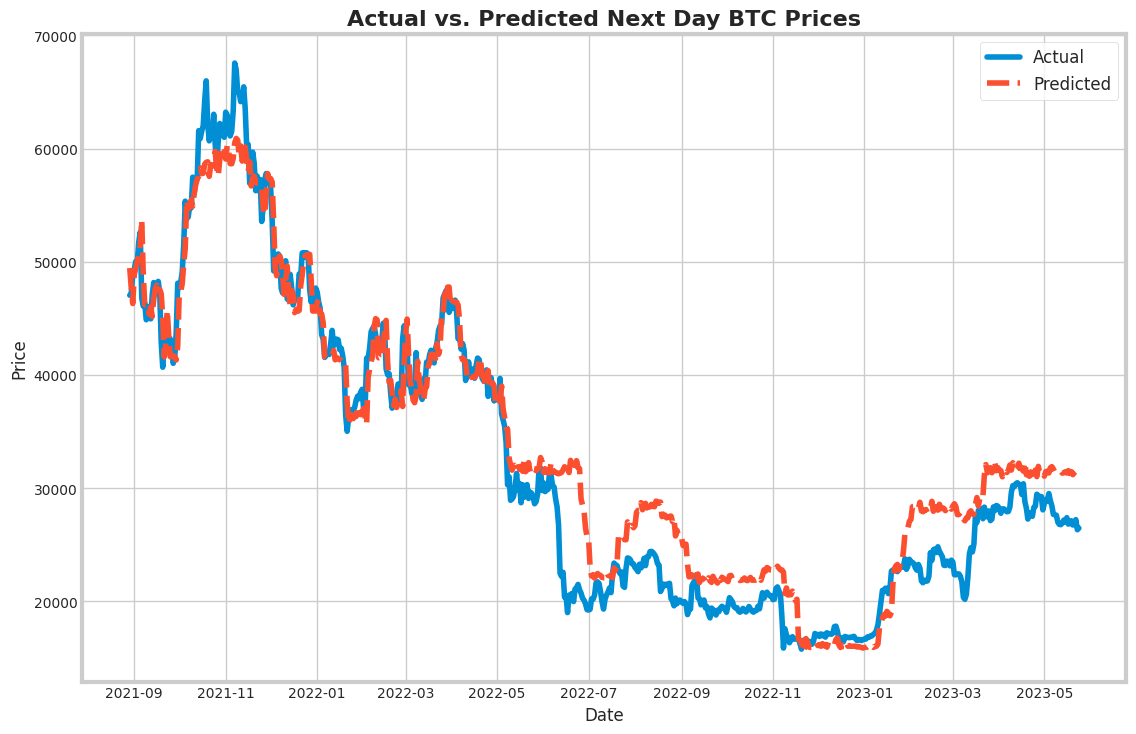

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for predictions and actual values
pred_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the actual and predicted values
sns.lineplot(data=pred_vs_actual[:-1])  # Excluding the last row to remove any incomplete data

# Set the plot title and labels
plt.title('Actual vs. Predicted Next Day BTC Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Set the legend
plt.legend(fontsize=12)

# Adjust the tick labels font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

### Hyperparameter tuning

###Linear regression


In [99]:
sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
sgd_reg.fit(x_train, y_train)

SGDRegressor(epsilon=0.01, learning_rate='adaptive',
             loss='squared_epsilon_insensitive', penalty='elasticnet',
             tol=1e-06)

In [100]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()
     

In [101]:
ytrain_pred = sgd_reg.predict(x_train)
ytest_pred = sgd_reg.predict(x_test)

MAE_test,RMSE_test = calculate_metrics(y_test,ytest_pred)
RMSE_test

1.0333053504995138e+26

In [ ]:
ytest_pred

In [102]:
pred_vs_actual = pd.DataFrame(data = [ytest_pred, y_test]).T
pred_vs_actual.columns = ['Pred', 'Actual']
pred_vs_actual['Date'] = x_test.index + pd.Timedelta('1 days')
pred_vs_actual = pred_vs_actual.set_index('Date')
pred_vs_actual

,Pred,Actual
Date,,
2021-08-30,8.512624e+25,47054.984375
2021-08-31,1.047130e+26,47166.687500
2021-09-01,1.141930e+26,48847.027344
2021-09-02,1.286891e+26,49327.722656
2021-09-03,1.299013e+26,50025.375000
...,...,...
2023-05-22,2.843448e+25,26851.277344
2023-05-23,3.635602e+25,27225.726563
2023-05-24,4.503731e+25,26334.818359


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for predictions and actual values
pred_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': ytest_pred})

# Set the figure size
plt.figure(figsize=(15, 12))

# Plot the actual and predicted values
sns.lineplot(data=pred_vs_actual)

# Set the plot title and labels
plt.title('Actual vs. Predicted BTC+1 Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Show the plot
plt.show()

### Baseline model = Random Forest Regressor 

In [112]:
from sklearn.ensemble import RandomForestRegressor
df_Random_Forest = df.copy()


model2 = RandomForestRegressor(n_estimators=1000, min_samples_split=50, random_state=1)

train = df_Random_Forest.iloc[:size]
test = df_Random_Forest.iloc[size:]


predictors = ["moving_avg",	"ema_12",	"ema_26",	"macd",	"macd_signal",	"rsi",	"aroon_oscillator", "Volume","sentiment", "Close"]
model2.fit(train[predictors], train["tomorrow"])


,Close,Volume,edit_count,sentiment,neg_sentiment,tomorrow,moving_avg,ema_12,ema_26,macd,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,13411.492689,457.334015,457.334015,0.000000,...,13412.982627,1.000000,5.033333,13392.230997,1.000000,5.033333,13161.172745,1.000000,5.033333,12114.559890
2014-09-18,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,13411.492689,452.273398,454.897421,-2.624024,...,424.440002,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002
2014-09-19,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,13411.492689,443.430720,450.445464,-7.014744,...,409.617996,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996
2014-09-20,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,13411.492689,438.118915,447.368318,-9.249402,...,401.849991,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995
2014-09-21,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,13411.492689,432.073084,443.772221,-11.699137,...,403.862503,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250


In [117]:
y_pred_training = model2.predict(train[predictors])
evaluate_model(train["tomorrow"], y_pred_training)

RMSE: 775.2919
R2 Score: 0.9963
MAPE: 2.72%
Directional Accuracy: 50.47%


In [118]:
y_pred = model2.predict(test[predictors])
evaluate_model(test["tomorrow"], y_pred)

RMSE: 4121.3735
R2 Score: 0.9064
MAPE: 11.75%
Directional Accuracy: 66.14%


Plot the baseline model  

(array([10000., 20000., 30000., 40000., 50000., 60000., 70000., 80000.]),
 [Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000'),
  Text(0, 80000.0, '80000')])

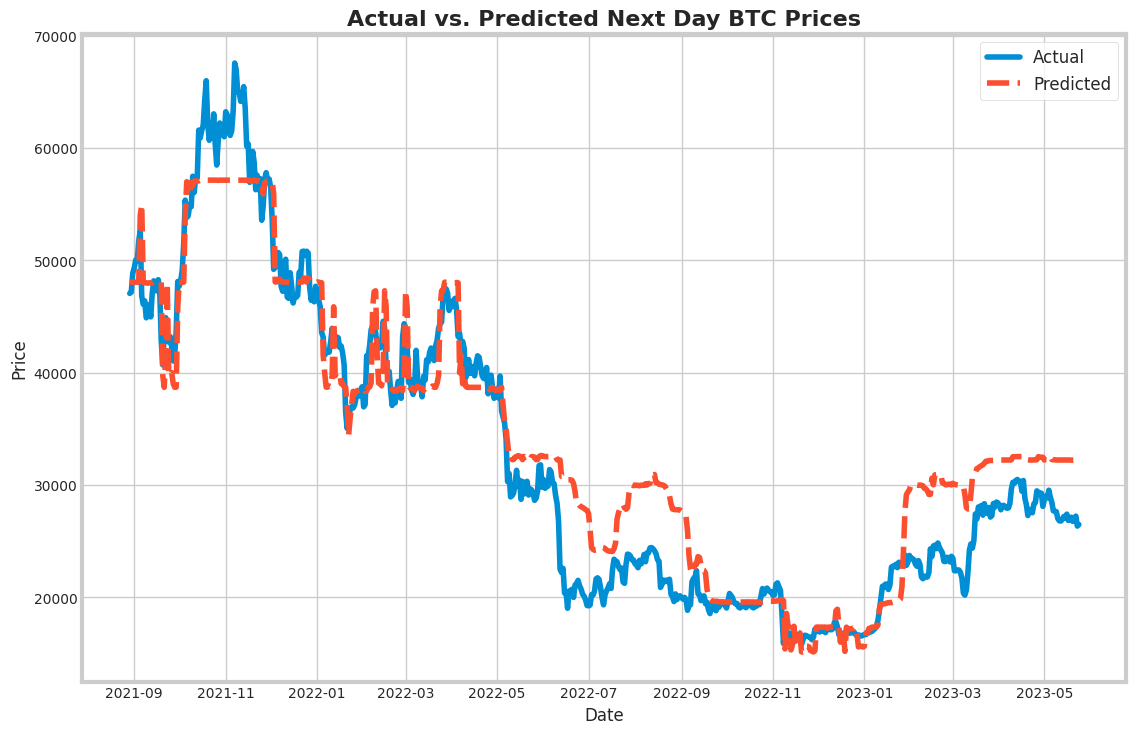

In [119]:
# Create a DataFrame for predictions and actual values
pred_vs_actual = pd.DataFrame({'Actual': test["tomorrow"], 'Predicted': y_pred})

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the actual and predicted values
sns.lineplot(data=pred_vs_actual[:-1])  # Excluding the last row to remove any incomplete data

# Set the plot title and labels
plt.title('Actual vs. Predicted Next Day BTC Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Set the legend
plt.legend(fontsize=12)

# Adjust the tick labels font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the pl

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LassoCV
# from sklearn.feature_selection import SelectFromModel
# from sklearn.model_selection import GridSearchCV

# def select_features_lasso(X, y):
#     # Perform Lasso feature selection
#     lasso = LassoCV(cv=5)
#     lasso.fit(X, y)

#     # Select features based on Lasso coefficients
#     sfm = SelectFromModel(lasso, threshold=1e-5)
#     sfm.fit(X, y)
#     X_selected = sfm.transform(X)

#     return X_selected, sfm.get_support()



In [ ]:
# X_selected, feature_mask = select_features_lasso(train[predictors], train["tomorrow"])

# rf = RandomForestRegressor()

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(rf, param_grid, cv=5, error_score='raise')
# X_selected


In [ ]:
# grid_search.fit(X_selected, train["tomorrow"])

In [136]:
from sklearn.ensemble import RandomForestClassifier
df_Random_Forest = df.copy()

df_Random_Forest["target"] = (df_Random_Forest["tomorrow"] > df_Random_Forest["Close"]).astype(int)


from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = df_Random_Forest.iloc[:size]
test = df_Random_Forest.iloc[size:]


predictors = ["moving_avg",	"ema_12",	"ema_26",	"macd",	"macd_signal",	"rsi",	"aroon_oscillator", "Volume","sentiment", "Close"]
model.fit(train[predictors], train["target"])
df_Random_Forest.head()


,Close,Volume,edit_count,sentiment,neg_sentiment,tomorrow,moving_avg,ema_12,ema_26,macd,...,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365,target
2014-09-17,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,13411.492689,457.334015,457.334015,0.000000,...,1.000000,5.033333,13392.230997,1.000000,5.033333,13161.172745,1.000000,5.033333,12114.559890,0
2014-09-18,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,13411.492689,452.273398,454.897421,-2.624024,...,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002,0.962696,5.050000,424.440002,0
2014-09-19,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,13411.492689,443.430720,450.445464,-7.014744,...,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996,0.927789,5.100000,409.617996,1
2014-09-20,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,13411.492689,438.118915,447.368318,-9.249402,...,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995,0.970419,5.125000,409.379995,0
2014-09-21,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,13411.492689,432.073084,443.772221,-11.699137,...,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250,0.956729,5.146667,406.740250,1


In [137]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.4853658536585366

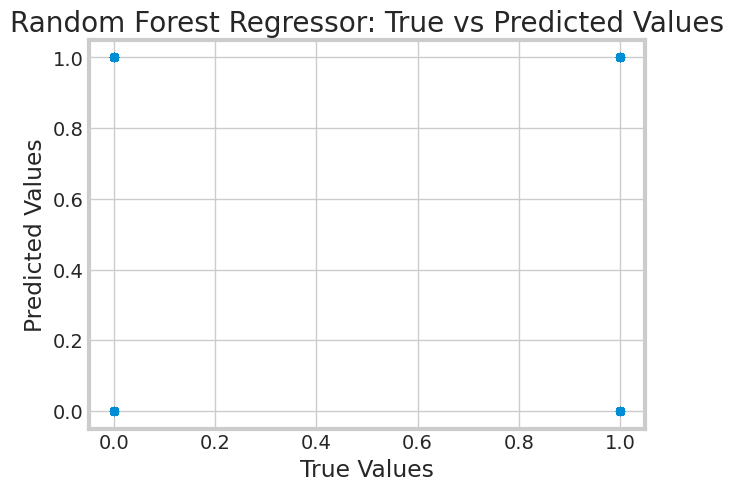

In [138]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(test[predictors])

# Create scatter plot
plt.scatter(test["target"], predictions)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regressor: True vs Predicted Values")
plt.show()

In [139]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [140]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [144]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(df_Random_Forest, model, predictors)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your predictions DataFrame has columns named "tomorrow" and "predictions"
actual_values = predictions["target"]
predicted_values = predictions["predictions"]

mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.5043310875842156
R-squared (R2): -1.0198858788000207


In [146]:
predictions["predictions"].value_counts()

1    1144
0     934
Name: predictions, dtype: int64

In [147]:
precision_score(predictions["target"], predictions["predictions"])


0.5122377622377622

In [148]:
from sklearn.metrics import r2_score


# Calculate R-squared score
r2 = r2_score(test["tomorrow"], predictions)
print("R-squared score: {:.2%}".format(r2))

ValueError: ignored

In [149]:
def compute_rolling(df_Random_Forest):
    horizons = [2,7,60,365]
    new_predictors = ["Close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = df_Random_Forest.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        df_Random_Forest[ratio_column] = df_Random_Forest["Close"] / rolling_averages["Close"]
        
        edit_column = f"edit_{horizon}"
        df_Random_Forest[edit_column] = rolling_averages["edit_count"]

        rolling = df_Random_Forest.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        df_Random_Forest[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return df_Random_Forest, new_predictors

In [151]:
# Get the correlations of the data
corr = df_Random_Forest.corr()

# Display Correlations of profit only
print("Correlations of Closing price only:")
corr['Close'].sort_values(ascending=False)

Correlations of Closing price only:


Close               1.000000
tomorrow            0.998686
ema_12              0.996833
ema_26              0.992009
moving_avg          0.990058
Volume              0.709250
sentiment           0.393384
macd_signal         0.178567
macd                0.164644
close_ratio_365     0.144063
close_ratio_60      0.038143
aroon_oscillator    0.032100
trend_365           0.016875
Momentum            0.016406
close_ratio_7       0.003861
close_ratio_2       0.001622
rsi                -0.035153
trend_2            -0.040661
target             -0.050542
trend_7            -0.072309
trend_60           -0.120981
edit_count         -0.345211
edit_2             -0.345713
edit_7             -0.349062
neg_sentiment      -0.390315
edit_60            -0.392926
edit_365           -0.536952
Name: Close, dtype: float64

In [152]:
mypred = list(set(new_predictors + predictors))
new_predictors

['Close',
 'sentiment',
 'neg_sentiment',
 'close_ratio_2',
 'trend_2',
 'edit_2',
 'close_ratio_7',
 'trend_7',
 'edit_7',
 'close_ratio_60',
 'trend_60',
 'edit_60',
 'close_ratio_365',
 'trend_365',
 'edit_365']

In [150]:
df_Random_Forest, new_predictors = compute_rolling(df_Random_Forest.copy())
predictions = backtest(df_Random_Forest, model, new_predictors)
precision_score(predictions["target"], predictions["predictions"])


0.5364238410596026

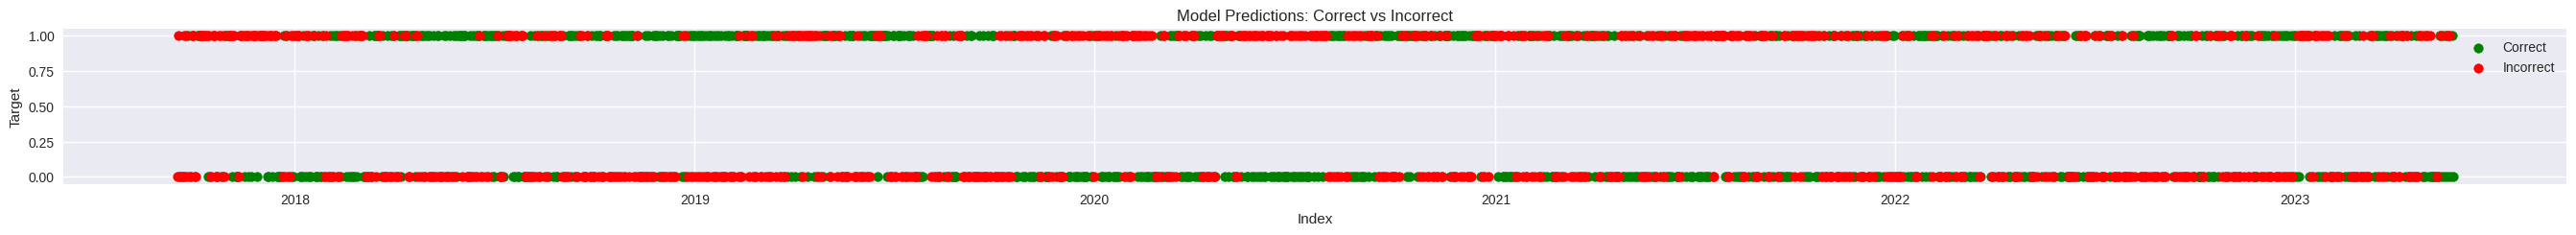

In [160]:
import matplotlib.pyplot as plt

# Create a DataFrame for correct and incorrect predictions
correct_predictions = predictions[predictions["target"] == predictions["predictions"]]
incorrect_predictions = predictions[predictions["target"] != predictions["predictions"]]

# Set the figure size and style
plt.figure(figsize=(30, 2))
plt.style.use("seaborn")

# Plot correct predictions as green dots
plt.scatter(correct_predictions.index, correct_predictions["target"], color="green", label="Correct")

# Plot incorrect predictions as red dots
plt.scatter(incorrect_predictions.index, incorrect_predictions["target"], color="red", label="Incorrect")

# Set the plot title and labels
plt.title("Model Predictions: Correct vs Incorrect")
plt.xlabel("Index")
plt.ylabel("Target")
plt.legend()

# Show the plot
plt.show()

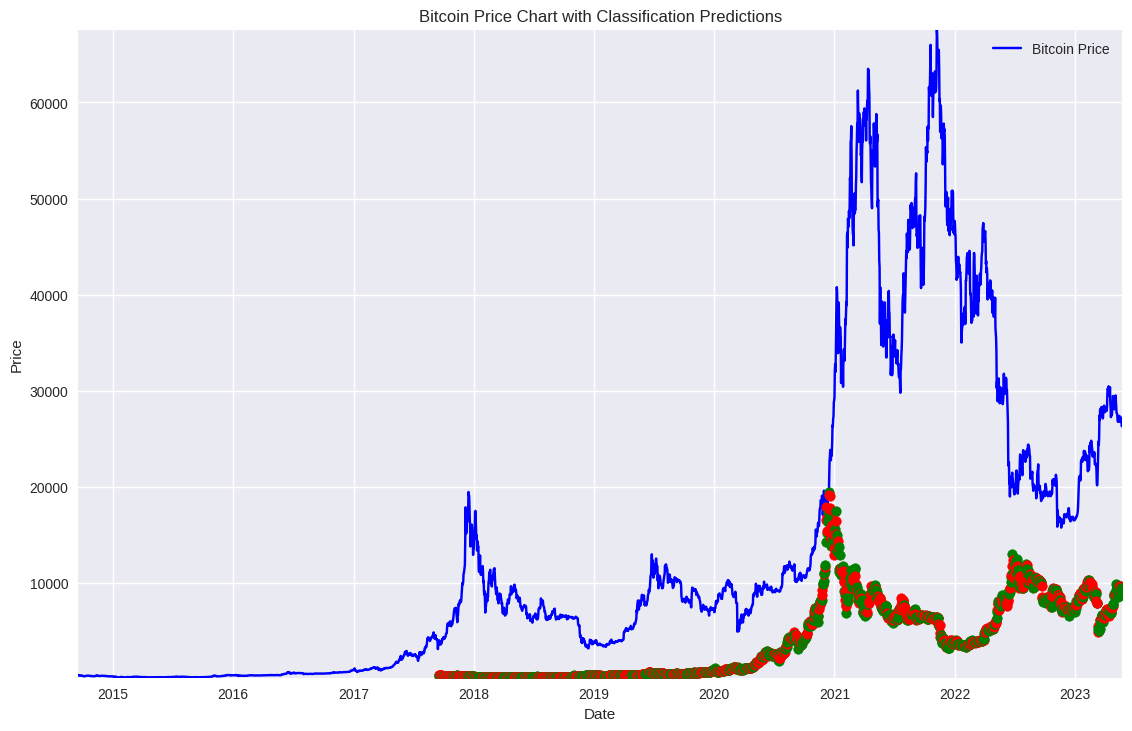

In [168]:

import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(12, 8))
plt.style.use("seaborn")

# Plot the Bitcoin price chart
plt.plot(df.index, df["Close"], color="blue", label="Bitcoin Price")

# Plot the correct predictions (green dots) and incorrect predictions (red dots)
for i in range(len(predictions)):
    if predictions["target"][i] == predictions["predictions"][i]:
        plt.scatter(predictions.index[i], df["Close"][i], color="green", marker="o", zorder=10)
    else:
        plt.scatter(predictions.index[i], df["Close"][i], color="red", marker="o", zorder=10)

# Set the plot title and labels
plt.title("Bitcoin Price Chart with Classification Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Adjust the plot to align the prediction points with the price chart
plt.autoscale(enable=True, axis="x", tight=True)
plt.autoscale(enable=True, axis="y", tight=True)


# Show the plot
plt.show()

In [153]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(predictions["target"], predictions["predictions"])
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 51.92%


In [154]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(predictions["target"], predictions["predictions"])
print(mse)

0.4807507218479307


In [ ]:
import tensorflow as tf

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(predictions["target"], predictions["predictions"])
accuracy_result = accuracy.result().numpy()

print("Accuracy: {:.2%}".format(accuracy_result))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, mean_squared_error

plt.figure(figsize=(12, 6))
plt.plot(predictions.index, predictions["target"], color='black', label='Actual')
plt.plot(predictions.index, predictions["predictions"], color='green', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

mse = mean_squared_error(predictions["target"], predictions["predictions"])
rmse = np.sqrt(mse)
r2 = r2_score(predictions["target"], predictions["predictions"])

print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

### LSTM Model

In [ ]:
!pip install pandas_ta
import pandas_ta as ta

In [ ]:
import yfinance as yf

data = pd.read_csv('Daily_Bitcoin_Prices.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head(10)

In [ ]:
# Adding TA indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

# Adding target column to the Data Frame - there are 3 ways of doing it 

# 1 difference between current open and close price
#data['Target'] = data['Adj Close']-data.Open

#data['Target'] = data['Target'].shift(-1)

# 2 ussing classification approach checking if we're going up or down binary
#data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

# 3 using closing price of the next day 
data['TargetNextClose'] = data['Adj Close'].shift(-1)


#data.dropna(inplace=True) ## maybe standard simple imputer mean instead of drop
#data_filled = data.fillna(data.mean())
data_filled = data.fillna(method='bfill')
final_data_filled = data_filled.fillna(method='ffill')
final_data_filled.drop(['Volume', 'Close'], axis=1, inplace=True)

In [ ]:
final_data_filled.tail()

In [ ]:
data_set = final_data_filled.copy()#.values
pd.set_option('display.max_columns', None)

data_set.tail(10)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

In [ ]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
#amount of candles used to predict next closing price data
backcandles = 30
print(data_set_scaled.shape[0])

# process the columns data for training
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

# X is input data for the model
#move axis from 0 to position 2 - 
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
# yi - the target, predicted data. Here i am choosing the I am choosing Closing price for the next day.
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

In [ ]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
data_X_train, data_X_test = X[:splitlimit], X[splitlimit:]
data_y_train, data_y_test = y[:splitlimit], y[splitlimit:]
print(data_X_train.shape)
print(data_X_test.shape)
print(data_y_train.shape)
print(data_y_test.shape)
print(data_y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=data_X_train, y=data_y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

In [ ]:
y_pred = model.predict(data_X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], data_y_test[i])

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size and create a new figure
plt.figure(figsize=(12, 6))

# Plot the test data in black
plt.plot(y_test, color='black', label='Actual')

# Plot the predicted values in green
plt.plot(y_pred, color='green', label='Predicted')

# Customize the x-axis ticks
plt.xticks([0, 250, 500, 750], ['2014', '2016', '2018', '2020'])

# Add axis labels and a title
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('LSTM Model Predictions')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data_y_test, y_pred))

# Calculate R2 score
r2 = r2_score(data_y_test, y_pred)

# Print the evaluation metrics
print("RMSE:", rmse)
print("R2 Score:", r2)




#### Prophet 

We need 

In [ ]:
#!pip install pystan==2.14

In [ ]:
#!pip install fbprophet

### Creating dataframe for Prophet

In [169]:
# Create a new DataFrame with 'ds' and 'y' columns
prophet_df = pd.DataFrame({'ds': df.index, 'y': df['Close']})

# Display the new DataFrame
print(prophet_df)

                   ds             y
2014-09-17 2014-09-17    457.334015
2014-09-18 2014-09-18    424.440002
2014-09-19 2014-09-19    394.795990
2014-09-20 2014-09-20    408.903992
2014-09-21 2014-09-21    398.821014
...               ...           ...
2023-05-21 2023-05-21  26753.826172
2023-05-22 2023-05-22  26851.277344
2023-05-23 2023-05-23  27225.726563
2023-05-24 2023-05-24  26334.818359
2023-05-25 2023-05-25  26476.207031

[3173 rows x 2 columns]


In [170]:
# Prophet model for time series forecast
# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [178]:
size = int(len(prophet_df) * 0.8)
df_train_prophet = prophet_df.iloc[:size]
df_test_prophet = prophet_df.iloc[size:]

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train_prophet), 'records, ranging from', df_train_prophet['ds'].min(), 'to', df_train_prophet['ds'].max())
print('The testing dataset has', len(df_test_prophet), 'records, ranging from', df_test_prophet['ds'].min(), 'to', df_test_prophet['ds'].max())

The training dataset has 2538 records, ranging from 2014-09-17 00:00:00 to 2021-08-28 00:00:00
The testing dataset has 635 records, ranging from 2021-08-29 00:00:00 to 2023-05-25 00:00:00


In [180]:
# Create the baseline prophet model with confidence internal of 95%
prophet = Prophet(interval_width=0.95)



In [181]:
import cmdstanpy

# Add technical analysis attributes as regressors to the model
# prophet.add_regressor('moving_avg')
# prophet.add_regressor('ema_12')
# prophet.add_regressor('ema_26')
# prophet.add_regressor('macd')
# prophet.add_regressor('macd_signal')
# prophet.add_regressor('rsi')
# prophet.add_regressor('aroon_oscillator')

# Fit the model using the training dataset
prophet.fit(df_train_prophet)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9gw64ric/2u9sf875.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9gw64ric/7kv8yjdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10911', 'data', 'file=/tmp/tmp9gw64ric/2u9sf875.json', 'init=/tmp/tmp9gw64ric/7kv8yjdy.json', 'output', 'file=/tmp/tmp9gw64ric/prophet_modelekwiueiy/prophet_model-20230529040717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [183]:
# Create a future dataframe for prediction
future = prophet.make_future_dataframe(periods=632)

# Extract the values for the technical analysis attributes from the original DataFrame
# moving_avg_values = df['moving_avg'].values
# ema_12_values = df['ema_12'].values
# ema_26_values = df['ema_26'].values
# macd_values = df['macd'].values
# macd_signal_values = df['macd_signal'].values
# rsi_values = df['rsi'].values
# aroon_oscillator_values = df['aroon_oscillator'].values

# Assign the attribute values to the regressor columns in the future DataFrame
# future['moving_avg'] = moving_avg_values
# future['ema_12'] = ema_12_values
# future['ema_26'] = ema_26_values
# future['macd'] = macd_values
# future['macd_signal'] = macd_signal_values
# future['rsi'] = rsi_values
# future['aroon_oscillator'] = aroon_oscillator_values

# Forecast the future dataframe values
forecast = prophet.predict(future)
# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3165,2023-05-18,109633.337724,84929.516031,135209.054650
3166,2023-05-19,109592.502712,85193.226217,138125.812791
3167,2023-05-20,109519.803478,84627.435140,134314.528706
3168,2023-05-21,109415.116439,82896.526362,134632.056747
3169,2023-05-22,109359.184756,82767.078470,136463.252301


In [184]:
from prophet.plot import plot_plotly

plot_plotly(prophet, forecast)

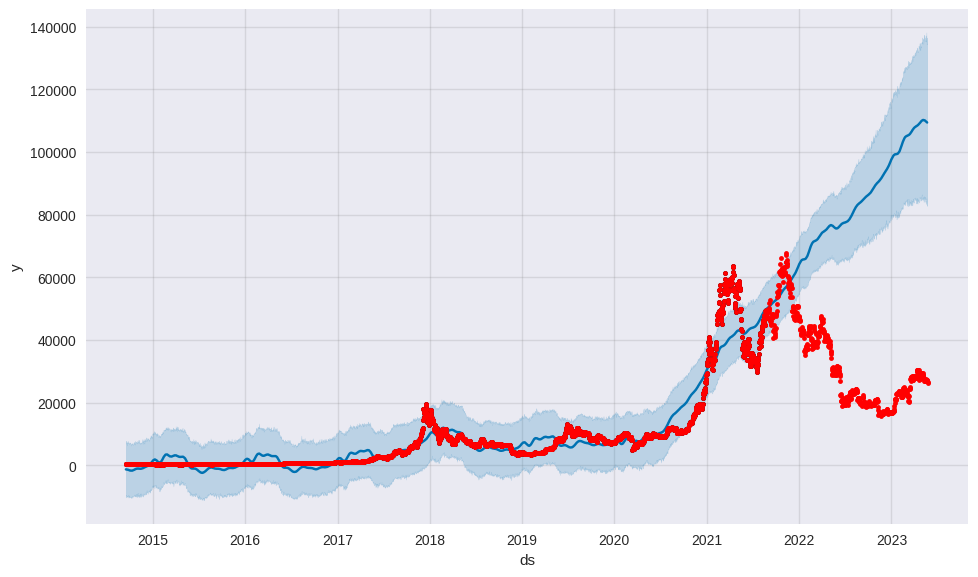

In [188]:
# Visualize the forecast
fig = prophet.plot(forecast)
ax = fig.gca()
ax.plot( prophet_df["ds"], prophet_df["y"], 'r.')

KeyError: ignored

<Figure size 1200x600 with 0 Axes>

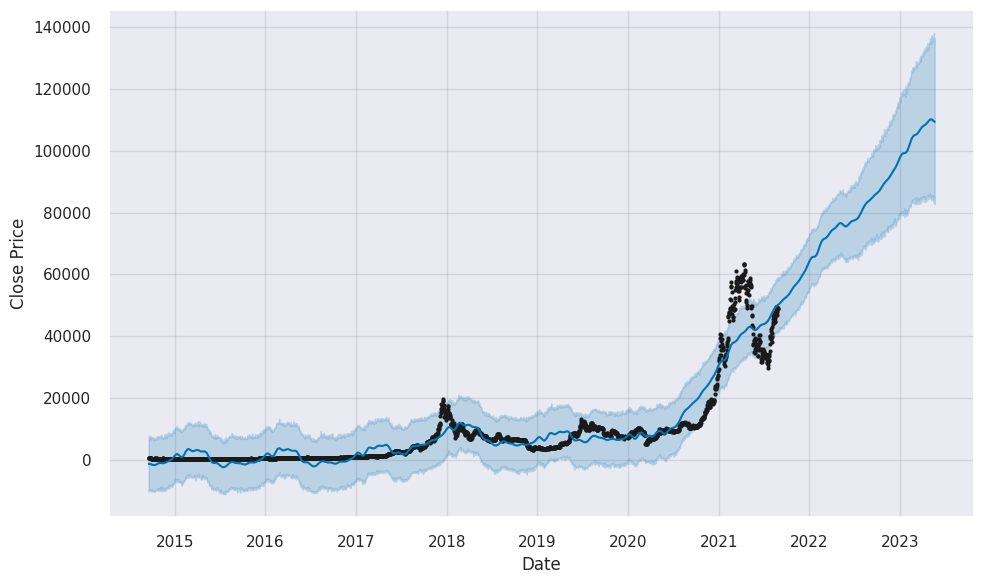

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the datetime column to datetime type if needed
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Set the style
sns.set(style='darkgrid')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the forecast
fig = prophet.plot(forecast, xlabel='Date', ylabel='Close Price')

# Get the predicted values for the test set
test_forecast = forecast[forecast['ds'].isin(prophet_df['ds'])]

# Plot the actual values from the test set
plt.plot(df_test['ds'], df_test['y'], 'r.', label='Actual')

# Plot the forecasted values for the test set
plt.plot(test_forecast['ds'], test_forecast['yhat'], 'b-', label='Forecast')

# Set the title
plt.title('Forecasted Close Prices')

# Set the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#test_forecast = forecast[forecast['ds'].isin(df_test['ds'])]
#print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


In [196]:
# Create a copy of the data
data_log = df_train_prophet.copy()

# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df_train_prophet['y'])

# Delete the stock price and rename the log scale stock price to y
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})

# Take a look at the data
data_log.head()

,ds,y
2014-09-17,2014-09-17,6.125414
2014-09-18,2014-09-18,6.050771
2014-09-19,2014-09-19,5.978369
2014-09-20,2014-09-20,6.013480
2014-09-21,2014-09-21,5.988513


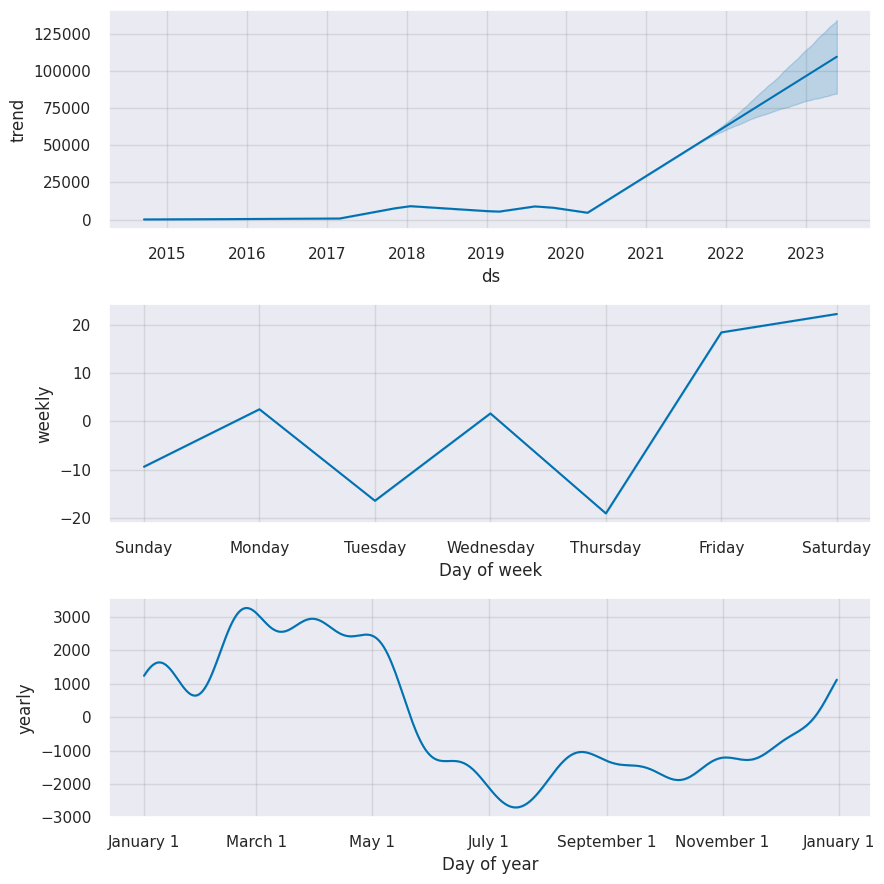

In [198]:
# Visualize the components
prophet.plot_components(forecast);

"Sell in May and go away" is a popular stock market adage or investing strategy that suggests selling stocks or reducing stock market exposure in May and staying away from the market until November. The phrase implies that investors could potentially avoid poor market performance during the summer months by selling their holdings and re-entering the market in the winter.

In [199]:
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import random


# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

param_combinations = 10  # Number of random parameter combinations to sample
random_params = random.sample(list(ParameterGrid(param_grid)), param_combinations)
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    df_cv = cross_validation(m, initial='1000 days', period='90 days', horizon='30 days')
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
best_params = all_params[np.argmin(mapes)]

# Best parameters
print(best_params)

NameError: ignored

In [ ]:
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import random


# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

param_combinations = 10  # Number of random parameter combinations to sample
random_params = random.sample(list(ParameterGrid(param_grid)), param_combinations)
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    df_cv = cross_validation(m, initial='1000 days', period='90 days', horizon='30 days')
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
best_params = all_params[np.argmin(mapes)]

# Best parameters
print(best_params)

In [200]:
# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{prophet_df.loc[prophet_df["ds"].isin(m.changepoints)]}')

NameError: ignored

In [201]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

NameError: ignored

In [202]:
# Cross validation
df_cv = cross_validation(m, initial='1000 days', period='30 days', horizon = '30 days', parallel="processes")
df_cv.head()

NameError: ignored

In [ ]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.tail(50)

In [ ]:
df_p.tail()

Evaluate the cross-validation model performance. 
* MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* RMSE (Root Mean Square Error) takes the square root of MSE.
* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

plot_cross_validation_metric method from Prophet helps us to plot the cross-validation performance results.

The x-axis is the horizon. Because we set the horizon to be 30 days, the x-axis has a value up to 30.
The y-axis is the metric we are interested in. We use mape as an example in this visualization.
On each day, we can see three dots. This is because there are three models in the cross-validation, and each dot represents the MAPE from one model.
The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

In [203]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

NameError: ignored

In [204]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mae')

NameError: ignored

In [ ]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')